In [1]:
##########################################
#### Import the necessary modules ########
##########################################
import numpy as np
from scipy.integrate import odeint
import astropy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
####################################################################
#### Input of measured values and allowed parameter ranges ########
####################################################################

#### Infection frequencies #########################################

## Measured values in the population that has reached its equilibrium:
# (in this case, these are the pooled values of populations 5 and 6)
SexTotal = 20 +20
SexInfected = 20 + 20
AsexTotal = 30 + 26
AsexInfected = 30 + 26


## Infection frequencies and alpha value estimates for 
## populations with spreading infections:
# (in this case populations 2 and 3)
## Population 2
infPop2 = 1
totalPop2 = 9
AlphamtDNAPop2 = 2
## Population 3
infPop3 = 13
totalPop3 = 20
AlphamtDNAPop3 = 3


## Measured rate of imperfect maternal transmission in the sexual generation
infOffspring = 129
totalOffspring = 148
uninfOffspring = totalOffspring - infOffspring



#### Parameter ranges ##############################################

## Definition of the value ranges for the parameters
µRangeMin, µRangeMax, µStepSize = 0.0,0.15,10
ßRangeMin, ßRangeMax, ßStepSize = 0.8,1.2,10
γRangeMin, γRangeMax, γStepSize = np.e**(-10),1.0,10
# We let γ approach zero as a minimum rather than setting it to zero directly because otherwise
# the equilibrium equations would give invalid results due to a division by zero.
# That in turn would lead to all the combinations with γ=0 not being taken into consideration.

## Set maximal allowed threshold of asexual generation infection frequency
thr = 0

In [3]:
###########################################
#### Definition of the model equations ####
###########################################

""" Defining the equations for the thresholds and equilibrium frequencies for the different generations.
    As demonstrated in the supplementary material, equations in the following definitions of "EqFSI" and "ThFSI" 
    can be obtained by inserting equation 2 into equation 1 of the paper and setting S_i,t+1/S_t = S_i,t/S_t 
    and solving for S_i,t/S_t. In the supplementary material, this results in equation 4, "EqFSI" and "ThFSI"
    correspond to the version of equation 4 using a "+" and a "-", respectively.
    Analogously, equation 1 can be inserted into equation 2 and we can set  A_i,t+1/A_t = A_i,t/A_t and solve for
    A_i,t/A_t. This was done to obtain the formulas for "EqFAI" and "ThFAI" as defined in the following.
    
    Inputs:
    The parameters µS,ßS,γ,µA,ßA as values between 0 and 1.
    
    Returns:
    Equilibrium frequencies as values between 0 and 1.
"""

# Equilibrium frequency of the sexual generation
def EqFSI (µS,ßS,γ,µA,ßA):
    return(((ßS*(-ßA+ßA*µS-µS)+γ+1)/(2*γ*(1-ßS*µS)))+(np.sqrt(((ßS*(ßA-ßA*µS+µS)-γ-1)**2)-4*γ*(1-ßS*µS)*(1-(ßA*(1-µA))*(1-µS)*ßS))/(2*γ*(1-ßS*µS))))

# Equilibrium frequency of the assexual (parthenogenetic) generation
def EqFAI (µS,ßS,γ,µA,ßA):
    return(ßA*(µA - 1)*np.sqrt(-4*µA*µS**2*ßA*ßS**2*γ + 4*µA*µS*ßA*ßS**2*γ + 4*µA*µS*ßA*ßS*γ - 4*µA*ßA*ßS*γ + µS**2*ßA**2*ßS**2 + 4*µS**2*ßA*ßS**2*γ - 2*µS**2*ßA*ßS**2 + µS**2*ßS**2 - 2*µS*ßA**2*ßS**2 - 4*µS*ßA*ßS**2*γ + 2*µS*ßA*ßS**2 - 2*µS*ßA*ßS*γ + 2*µS*ßA*ßS + 2*µS*ßS*γ - 2*µS*ßS + ßA**2*ßS**2 + 2*ßA*ßS*γ - 2*ßA*ßS + γ**2 - 2*γ + 1)/(2*(µA**2*µS*ßA**2*ßS*γ - µA**2*ßA**2*γ - 2*µA*µS*ßA**2*ßS*γ + µA*ßA**2*ßS + µA*ßA**2*γ - µA*ßA**2 - µA*ßA*ßS + µA*ßA*γ + µA*ßA + µS*ßA**2*ßS*γ - ßA**2*ßS + ßA*ßS - ßA*γ + ßA - 1)) - (µA*µS*ßA**2*ßS - µA*µS*ßA*ßS - µA*ßA**2*ßS + 2*µA*ßA*ßS - µA*ßA*γ - µA*ßA - µS*ßA**2*ßS + µS*ßA*ßS + ßA**2*ßS - 2*ßA*ßS + ßA*γ - ßA + 2)/(2*(µA**2*µS*ßA**2*ßS*γ - µA**2*ßA**2*γ - 2*µA*µS*ßA**2*ßS*γ + µA*ßA**2*ßS + µA*ßA**2*γ - µA*ßA**2 - µA*ßA*ßS + µA*ßA*γ + µA*ßA + µS*ßA**2*ßS*γ - ßA**2*ßS + ßA*ßS - ßA*γ + ßA - 1)))

# Threshold frequency of the sexual generation
def ThFSI (µS,ßS,γ,µA,ßA):
    return(((ßS*(-ßA+ßA*µS-µS)+γ+1)/(2*γ*(1-ßS*µS)))-(np.sqrt(((ßS*(ßA-ßA*µS+µS)-γ-1)**2)-4*γ*(1-ßS*µS)*(1-(ßA*(1-µA))*(1-µS)*ßS))/(2*γ*(1-ßS*µS))))

# Threshold frequency of the assexual (parthenogenetic) generation
def ThFAI (µS,ßS,γ,µA,ßA):
    return(-ßA*(µA - 1)*np.sqrt(-4*µA*µS**2*ßA*ßS**2*γ + 4*µA*µS*ßA*ßS**2*γ + 4*µA*µS*ßA*ßS*γ - 4*µA*ßA*ßS*γ + µS**2*ßA**2*ßS**2 + 4*µS**2*ßA*ßS**2*γ - 2*µS**2*ßA*ßS**2 + µS**2*ßS**2 - 2*µS*ßA**2*ßS**2 - 4*µS*ßA*ßS**2*γ + 2*µS*ßA*ßS**2 - 2*µS*ßA*ßS*γ + 2*µS*ßA*ßS + 2*µS*ßS*γ - 2*µS*ßS + ßA**2*ßS**2 + 2*ßA*ßS*γ - 2*ßA*ßS + γ**2 - 2*γ + 1)/(2*(µA**2*µS*ßA**2*ßS*γ - µA**2*ßA**2*γ - 2*µA*µS*ßA**2*ßS*γ + µA*ßA**2*ßS + µA*ßA**2*γ - µA*ßA**2 - µA*ßA*ßS + µA*ßA*γ + µA*ßA + µS*ßA**2*ßS*γ - ßA**2*ßS + ßA*ßS - ßA*γ + ßA - 1)) - (µA*µS*ßA**2*ßS - µA*µS*ßA*ßS - µA*ßA**2*ßS + 2*µA*ßA*ßS - µA*ßA*γ - µA*ßA - µS*ßA**2*ßS + µS*ßA*ßS + ßA**2*ßS - 2*ßA*ßS + ßA*γ - ßA + 2)/(2*(µA**2*µS*ßA**2*ßS*γ - µA**2*ßA**2*γ - 2*µA*µS*ßA**2*ßS*γ + µA*ßA**2*ßS + µA*ßA**2*γ - µA*ßA**2 - µA*ßA*ßS + µA*ßA*γ + µA*ßA + µS*ßA**2*ßS*γ - ßA**2*ßS + ßA*ßS - ßA*γ + ßA - 1)))



def AlphaShares (FI0,t,µA,ßA,γ,µS,ßS):
    
    """ Defining the differential equation extending the basic model with alpha values.
    The equations defined here are equivalent to equations 1,2, 7 and 8 of the manuscript with the 
    added terms "-FSI", "-FAI", "-FaS", "-FaA". 
    This way, the change of frequencies instead of the actual frequencies are calculated.
    This function can be used with numpys odeint to solve the differential equations and return 
    infection frequencies at each point in time.
    
    Inputs:
    FSI0: Either one initial frequency of the infection, set to a value between 0 and 1, can be provided in order
    to solve the differential equation for this initial frequency.
    Alternatively, an array of frequencies for which to calculate the derivative given the defined equation can be
    given. This is used to visualize the differential equation itself.
    t: An array containing a sequence of monotonically increasing time points for which to solve the differential equation.
    
    Returns:
    If a single value was provided for FSI0, the function returns the derivatives of the infection frequencies and
    alpha values for this specific value. If multiple values were provided, this is done for each of them.
    
    """
    
    FSI=FI0[0]
    FAI=FI0[1]
    FaS=FI0[2]
    FaA=FI0[3]
    
    ## Basic model
    # Equation 1:
    dFSIdt = ((ßA*(1-µA))/(ßA-1+(1/FAI)))-FSI
    # Equation 2:
    dFAIdt = (((1-µS)*ßS)/(ßS*(1-µS*γ*FSI)+(((1/FSI)-1)*(1-γ*FSI))))-FAI
    
    ## Model extension
    # Equation 7:
    dFaSdt = 1 - ((1-FaA)/((µA*ßA*FAI)/(1-FAI)+1)) - FaS
    # Equation 8:
    dFaAdt = 1 - ((1-FaS)/((µS*ßS*FSI)/(1-FSI)+1)) - FaA
    
    return(dFSIdt,dFAIdt,dFaSdt,dFaAdt)



def FI_initial (F0,γ,µS,ßS):
    
    """ Calculating the initial infection frequency in the parthenogenetic generation depending on the initial value of 
    the sexual generation in which the infection was introduced.
    
    Inputs:
    F0: Initial infection frequency of the sexual generation as a value between 0 and 1.
    γ,µS,ßS: Parameters
    
    Returns:
    Initial infection frequency of the parthenogenetic generation as a value between 0 and 1.
    """
    
    FSI_initial = F0
    FAI_initial = (((1-µS)*ßS)/(ßS*(1-µS*γ*F0)+(((1/F0)-1)*(1-γ*F0))))
    
    # Initial frequency of alpha values is set to 0 by default.
    FaS_initial = 0
    FaA_initial = 0
    
    return(FSI_initial,FAI_initial,FaS_initial,FaA_initial)

In [4]:
##########################################################################
#### Statistical Analsis: Calculation of the 95% confidence intervals ####
##########################################################################

#### For infection frequencies ######################

## Pooled infection frequencies of populations 5 and 6
lSexFreq = astropy.stats.binom_conf_interval(SexInfected,SexTotal, confidence_level=0.95, interval='wilson')[0]
uSexFreq = astropy.stats.binom_conf_interval(SexInfected,SexTotal, confidence_level=0.95, interval='wilson')[1]
lAsexFreq = astropy.stats.binom_conf_interval(AsexInfected,AsexTotal, confidence_level=0.95, interval='wilson')[0]
uAsexFreq = astropy.stats.binom_conf_interval(AsexInfected,AsexTotal, confidence_level=0.95, interval='wilson')[1]

# lSexFreq and lAsexFreq are the lower limits of the confidence intervals and
# uSexFreq and uAsexFreq are the upper limits

print("pooled infection frequencies of populations 5 and 6:","\n",
      "95% Wilson confidence interval of the sexual generation is (",lSexFreq,",",uSexFreq,")","\n",
      "95% Wilson confidence interval of the parthenogenetic generation is (",lAsexFreq,",",uAsexFreq,")","\n")

## Population 2
NOTinfPop2 = totalPop2-infPop2
FDIGmtDNAPop2_95 = astropy.stats.binom_conf_interval(infPop2,totalPop2, confidence_level=0.95, interval='wilson')

## Population 3
NOTinfPop3 = totalPop3-infPop3
FDIGmtDNAPop3_95 = astropy.stats.binom_conf_interval(infPop3,totalPop3, confidence_level=0.95, interval='wilson')

print("infection frequencies of populations 2 and 3:","\n",
      "95% Wilson confidence interval of Population 2 (parthenogenetic generation) is (",FDIGmtDNAPop2_95[0],",",FDIGmtDNAPop2_95[1],")","\n",
      "95% Wilson confidence interval of Population 3 (sexual generation) is (",FDIGmtDNAPop3_95[0],",",FDIGmtDNAPop3_95[1],")","\n")



#### For alpha values ##############################

## Population2
FinfPop2_95 = astropy.stats.binom_conf_interval(AlphamtDNAPop2,NOTinfPop2, confidence_level=0.95, interval='wilson')

## Population3
FinfPop3_95 = astropy.stats.binom_conf_interval(AlphamtDNAPop3,NOTinfPop3, confidence_level=0.95, interval='wilson')

print("alpha values of populations 2 and 3:","\n",
      "95% Wilson confidence interval of Population 2 (parthenogenetic generation) is (",FinfPop2_95[0],",",FinfPop2_95[1],")","\n",
      "95% Wilson confidence interval of Population 3 (sexual generation) is (",FinfPop3_95[0],",",FinfPop3_95[1],")","\n")



#### For maternal transmission values ##############################
µSrange = astropy.stats.binom_conf_interval(uninfOffspring,totalOffspring, confidence_level=0.95, interval='wilson')
µSrange[1] = 0.15 if µSrange[1]>0.15 else µSrange[1]

print (" 95% Wilson confidence interval of measured imperfect maternal transmission of the sexual generation is (",µSrange[0],",",µSrange[1],")")

pooled infection frequencies of populations 5 and 6: 
 95% Wilson confidence interval of the sexual generation is ( 0.9123783988027133 , 0.9999999999999999 ) 
 95% Wilson confidence interval of the parthenogenetic generation is ( 0.9358060632812366 , 1.0 ) 

infection frequencies of populations 2 and 3: 
 95% Wilson confidence interval of Population 2 (parthenogenetic generation) is ( 0.019890887638544935 , 0.4349997055766561 ) 
 95% Wilson confidence interval of Population 3 (sexual generation) is ( 0.43285427668523624 , 0.818808175898918 ) 

alpha values of populations 2 and 3: 
 95% Wilson confidence interval of Population 2 (parthenogenetic generation) is ( 0.071479212752109 , 0.5907245696898311 ) 
 95% Wilson confidence interval of Population 3 (sexual generation) is ( 0.1582198552514697 , 0.7495416354723428 ) 

 95% Wilson confidence interval of measured imperfect maternal transmission of the sexual generation is ( 0.08374954261664821 , 0.15 )


In [7]:
#########################################################################################
#### Approach 1: Calculating the minimum level of CI necessary to explain measured µ ####
#########################################################################################

def γSmin (eqFSImax,eqFAImin,ßmax,µmin):
    
    """ Calculate the minimum γ necessary to explain empirical data.
    As described in the manuscript and supplement, we obtain the minimum γ when we go from highest 
    possible frequency in the sexual generation to the lowest possible infection frequency in the 
    asexual generation while keeping ß high and µ as low as possible. 
    This way, the loss of infection amongst the offspring of the sexual generation is at it's maximum 
    even though the maternal transmission is assumed to be as complete as it can be without deviating 
    significantly from the measurements and the infected mother experience the maximum reproductive advantage. 
    
    Inputs:
    eqFSImax: Upper bound of the confidence interval calculated for infection frequency observed in the sexual 
              generation as a value between 0 and 1.
    eqFAImin: Lower bound of the confidence interval calculated for infection frequency observed in the asexual 
              generation as a value between 0 and 1.
    ßmax: Highest ß allowed in our parameter ranges as a value between 0 and 1.
    µmin:Lower bound of the confidence interval calculated for the observed maternal transmission as a value 
         between 0 and 1.
    
    Returns:
    Minimum γ necessary to explain empirical data as a value between 0 and 1.
    """
    
    γ_ = ((-1*eqFAImin*((1/eqFSImax)-1+ßmax))+(ßmax*(1-µmin)))/(eqFAImin*(eqFSImax*(1-ßmax*µmin)-1))
    return(γ_)

print("minimum γ is",γSmin(uSexFreq,lAsexFreq,ßRangeMax,µSrange[0]))    

minimum γ is 0.2495186302962442


/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/3565306713.py:30: RuntimeWarning: invalid value encountered in sqrt
  return(((ßS*(-ßA+ßA*µS-µS)+γ+1)/(2*γ*(1-ßS*µS)))-(np.sqrt(((ßS*(ßA-ßA*µS+µS)-γ-1)**2)-4*γ*(1-ßS*µS)*(1-(ßA*(1-µA))*(1-µS)*ßS))/(2*γ*(1-ßS*µS))))


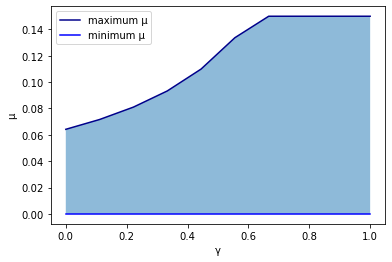

In [6]:
#####################################################################################
#### Creation of the matrix containing all possible parameter value combinations ####
#####################################################################################


#### Limiting the range of µ #########################################################

# In this step, the range of µ will be limited to the minimum and maximum values
# for each generation, that can result in the observed infection frequencies. This way,
# I can let the parameter range only between these values and thereby make the grid finer,
# which will make the results more nuanced. Other than just choosing a higher step size, 
# which would also result in more nuanced results, this will not increase the number of
# parameter combinations that have to be examined and thereby it will not increase computing
# time.
# This step is therefore not strictly necessary, but it can be useful when using slower computers.
# For the following calculations the equations for the infection frequencies in the sexual and
# asexual generations were solved for µ.

## Parthenogenetic generation:
def µAmax (eqFSImin,eqFAImax,ßmax):
    
    """ Calculate the maximum µ in the parthenogenetic generation.
    We get the maximum possible µ when we go from highest possible infection frequency in the parthenogenetic 
    generation to lowest possible infection frequency in the sexual generation while assuming the highest
    possible ß. The µ value necessary for this has to be the maximal one because the loss of infection
    amongst the offspring of the asexual generation is as high as it possibly could be without deviating
    significantly from the measured data despite the reproductive advantage of infected mothers being maximal. 
    
    Inputs:
    eqFSImin: Lower bound of the confidence intervals of the infection frequency in the sexual generation as a 
    value between 0 and 1.
    eqFAImax: Upper bound of the confidence intervals of the infection frequency in the parthenogenetic 
    generation as a value between 0 and 1.
    ßmax: Highest ß allowed in our parameter ranges as a value between 0 and 1.
    
    Returns:
    Maximum possible µ in the parthenogenetic generation as a value between 0 and 1.
    """
    µ_ = (eqFSImin/ßmax)*(1-(1/eqFAImax)-ßmax)+1
    µ = µ_ if µ_<=µRangeMax else µRangeMax   
    return(µ)

def µAmin (eqFSImax,eqFAImin,ßmin):
    
    """ Calculate the minimum µ in the parthenogenetic generation.
    Similarly, we can calculate the minimum possible µ by going from the lowest possible infection frequency
    in the parthenogenetic generation to the highest possible one in the sexual generation while assuming the 
    minimum ß. 
    
    Inputs:
    eqFSImax: Upper bound of the confidence intervals of the infection frequency in the sexual generation as a 
              value between 0 and 1.
    eqFAImin: Lower bound of the confidence intervals of the infection frequency in the parthenogenetic 
              generation as a value between 0 and 1.
    ßmin: Lowest ß allowed in our parameter ranges as a value between 0 and 1.
    
    Returns:
    Minimum possible µ in the parthenogenetic generation as a value between 0 and 1.
    """
    
    µ_ = (eqFSImax/ßmin)*(1-(1/eqFAImin)-ßmin)+1
    µ = µ_ if µ_>=µRangeMin else µRangeMin
    return(µ)


## Sexual generation:

def µSmax (eqFSImax, eqFAImin,γ,ßmax):
    
    """ Calculate the maximum µ in the sexual generation.
    Like in the parthenogenetic generation, we get the maximum µ when we go from the highest possible 
    Infection frequency of the sexual generation to the lowest possible one in the parthenogenetic generation 
    while keeping ß maximum. This time we however also have to take into account CI, therefore, we need
    to calculate this for every examined level of CI.
    
    Inputs:
    eqFSImax: Upper bound of the confidence intervals of the infection frequency in the sexual generation as a 
              value between 0 and 1.
    eqFAImin: Lower bound of the confidence intervals of the infection frequency in the parthenogenetic 
              generation as a value between 0 and 1.
    γ: Array with the different levels of CI that should be taken into consideration.
    ßmax: Highest ß allowed in our parameter ranges as a value between 0 and 1.
    
    Returns:
    Maximum possible µ in the sexual generation as a value between 0 and 1.
    """
    
    µ = (-1*eqFAImin*((1/eqFSImax)+γ*eqFSImax-γ-1+ßmax)+ßmax)/(ßmax-eqFAImin*γ*eqFSImax*ßmax)
    µ[µ>=0.15]=0.15
    return(µ)

def µSmin (eqFSImin, eqFAImax,γ,ßmin):
    
    """ Calculate the minimal µ in the sexual generation.
    Similarly, we can calculate the minimum possible µ by going from the lowest possible infection frequency
    in the sexual generation to the highest possible one in the parthenogenetic generation while assuming the 
    minimum ß.
    
    Inputs:
    eqFSImin: Lower bound of the confidence intervals of the infection frequency in the sexual generation as a 
              value between 0 and 1.
    eqFAImax: Upper bound of the confidence intervals of the infection frequency in the parthenogenetic 
              generation as a value between 0 and 1.
    γ: Array with the different levels of CI that should be taken into consideration.
    ßmin: Lowest ß allowed in our parameter ranges as a value between 0 and 1.
    
    Returns:
    Minimal possible µ in the sexual generation as a value between 0 and 1.
    """
    
    µ = (-1*eqFAImax*((1/eqFSImin)+γ*eqFSImin-γ-1+ßmin)+ßmin)/(ßmin-eqFAImax*γ*eqFSImin*ßmin)
    µ[µ<=0]=0
    return(µ)

# We first need to define the range of CI levels:
γ0 = np.linspace(γRangeMin,γRangeMax,γStepSize)

# Now we can calcualte the maximum and minimum µS values for each given γ:
µSmaxRange = µSmax(uSexFreq,lAsexFreq,γ0,ßRangeMax)
µSminRange = µSmin(lSexFreq,uAsexFreq,γ0,ßRangeMin)

# Using this, we can visualize the possible values µ can take on for given levels of CI:
# This graph was not included in the publication but might be useful to visualize what was done in this step
plt.plot(γ0,µSmaxRange, color="darkblue", label="maximum µ")
plt.plot(γ0,µSminRange, color="blue", label="minimum µ")
plt.fill_between(γ0,µSminRange,µSmaxRange,alpha=0.5)
plt.ylabel("µ")
plt.xlabel("γ")
plt.legend()



#### Creation of the actual matrix ###################################################

## Creation of linearly spaced arrays of parameter values for each of the five parameters:
µA = np.linspace(µAmin(uSexFreq,lAsexFreq,ßRangeMin),µAmax(lSexFreq,uAsexFreq,ßRangeMax),µStepSize)
ßA = np.linspace(ßRangeMin,ßRangeMax,ßStepSize)
µS = np.linspace(µRangeMin,µRangeMax,µStepSize)
ßS = np.linspace(ßRangeMin,ßRangeMax,ßStepSize)

## Creation of a grid of these arrays:
µA_,γ_,ßA_,ßS_,µS_ = np.meshgrid(µA,γ0,ßA,ßS,µS)

## Replacing the values for µS with the ranges of maximum and minimum ones:
# Since they need to be placed in the grid so that they correspond to the
# correct level of CI, we can not simply calculate the linspace for these µ values but
# have to calculate them separately and replace them in the grid.
# Given the previously calculated maximum and minimum µS values for each given γ we can
# replace the µS values in the grid for given γ values with the values in the new range 
# for µS corresponding to the specific γ levels:
for i in range(0,len(γ0)):
    µRangeByγ = np.linspace(µSminRange[i],µSmaxRange[i],µStepSize)
    µS_[i] = np.tile(np.tile(np.tile([µRangeByγ],(ßStepSize,1)),(ßStepSize,1,1)),(µStepSize,1,1,1))

## Generating the actual matrix:
# First we need to set up an empty array to which we can append the calculated values:
count = 0
combMatrix=np.array([np.empty([8])])
# Now we can use several for-loops to calculate the infection frequencies at equilibrium as well as the
# threshold frequencies for every single possible combination of parameter-values.
# We then attach the parameter values as well as the infection frequencies at equilibrium to our Matrix 
# for each combination for which the threshold frequency is not bigger than allowed and for which the 
# resulting equilibrium frequencies exist and do not deviate significantly from the observed values.
# That leaves us with a matrix of all value combinations that can plausibly explain the observed infection 
# frequencies in populations 5 and 6.
# Since some combinations of values might not result in equilibrium frequencies, some combinations might result
# in invalid operations like negative values under roots and therefore trigger warnings.
for i in range(0,γStepSize):
    for j in range(0,µStepSize):
        for k in range(0,ßStepSize):
            for l in range(0,ßStepSize):
                for m in range(0,µStepSize):
                    
                    µA = µA_[i][j][k][l][m]
                    ßA = ßA_[i][j][k][l][m]
                    γ = γ_[i][j][k][l][m]
                    µS = µS_[i][j][k][l][m]
                    ßS = ßS_[i][j][k][l][m]
                    
                    ThrSex = ThFSI(µS,ßS,γ,µA,ßA)
                    if np.logical_and(not np.isnan(ThrSex),ThrSex<=thr):
                        
                        FeqAsex = EqFAI(µS,ßS,γ,µA,ßA)
                        if np.logical_and(not np.isnan(FeqAsex),np.logical_and(FeqAsex>=lAsexFreq,FeqAsex<=uAsexFreq)):
                            
                            FeqSex = EqFSI(µS,ßS,γ,µA,ßA)
                            if np.logical_and(not np.isnan(FeqSex),np.logical_and(FeqSex>=lSexFreq,FeqSex<=uSexFreq)):
                                combMatrix = np.append(combMatrix,[[µA,ßA,γ,µS,ßS,ThrSex,FeqAsex,FeqSex]], axis=0)
                    
    # We print a text to tell us how far the analysis has come:
    print(i/len(γ0)*100,"%", end = "\r")

# We need to remove the first line of the matrix that is filled with values created by the np.empty command,
# otherwise these values will cause issues with our calculations later on.
combMatrix = combMatrix[1:]



/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/164140775.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(0.8,0.1,"ro",color="orange",label="alpha value of 0.1 for infection frequency of 0.8")
/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/164140775.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(0.8,0.5,"ro",color="red",label="alpha value of 0.5 for infection frequency of 0.8")


/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/164140775.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(0.8,0.1,"ro",color="orange",label="alpha value of 0.1 for infection frequency of 0.8")
/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/164140775.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(0.8,0.5,"ro",color="red",label="alpha value of 0.5 for infection frequency of 0.8")


/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/3565306713.py:73: RuntimeWarning: invalid value encountered in double_scalars
  dFaSdt = 1 - ((1-FaA)/((µA*ßA*FAI)/(1-FAI)+1)) - FaS
/var/folders/18/5bbnsvln21q_vvywbb2vs6wh0000gn/T/ipykernel_6329/3565306713.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  dFaAdt = 1 - ((1-FaS)/((µS*ßS*FSI)/(1-FSI)+1)) - FaA


done finding maximum and minimum mtDNA values in sexual generation
done finding maximum and minimum mtDNA values in Asexual generation


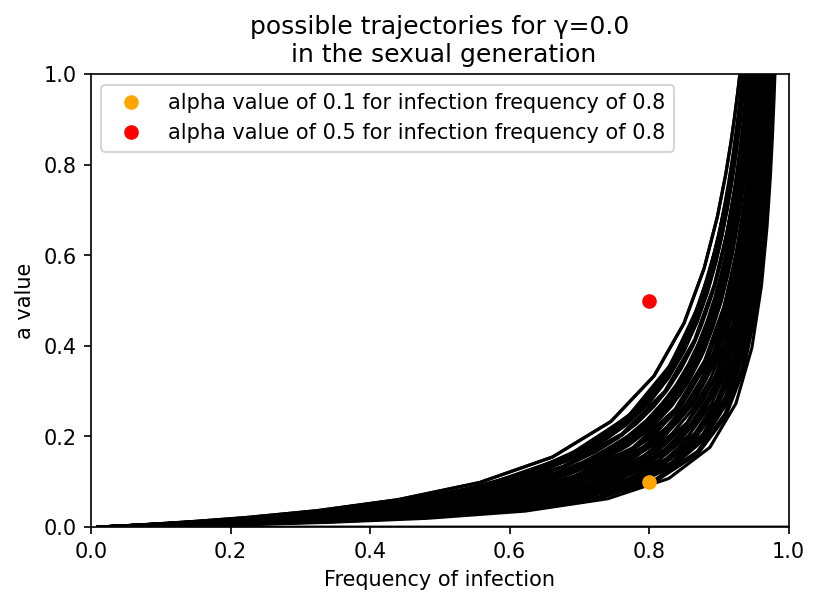

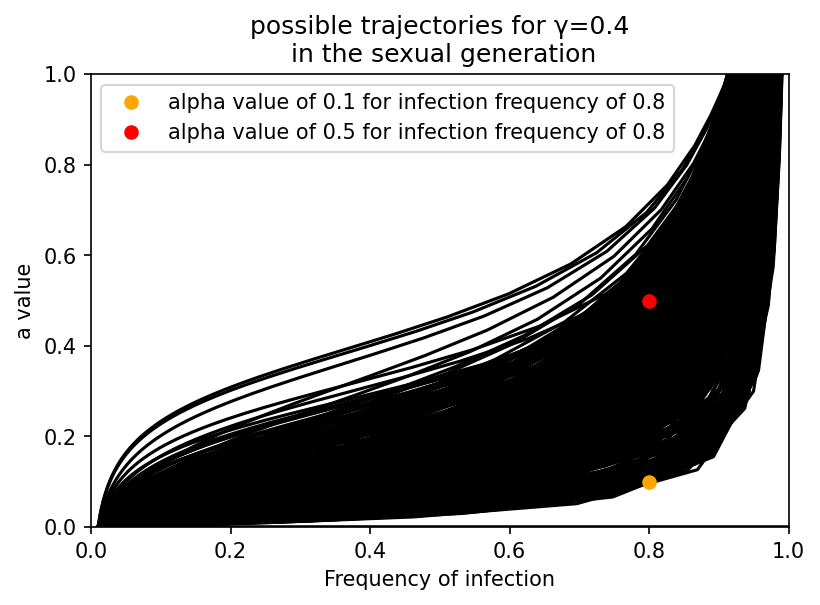

In [11]:
########################################################################################################
#### Supplemental figure 3: ############################################################################
#### Finding parameter combination with the maximum and minimum alpha values for given levels of CI ####
########################################################################################################

# Before starting with the actual calculations, we need to decide for how many generations the spread
# of Wolbachia and the alpha mtDNA will be simulated. We choose a high number of generations (1500) to 
# ensure that even those interactions, which result in a very slow spread, will be simulated until they 
# reach their equilibrium frequency.
# I choose to only simulate for a smaller number of time points (450) to speed up the calculations.
t = np.linspace(0,1500,450)

# Set the initial frequency:
F0THzero = 0.01

#### Calculate the lowest and highest alpha values in sexual generations for given levels of CI #####

# First we set up a matrix in which we will store the indices of our combMatrix, in which all the parameter 
# combinations resulting in observed equilibrium frequencies are stored, at which the combinations resulting
# in the maximum and minimum alpha value for a given level of CI are stored.
MaxMinS = [γ0,np.repeat(-1,len(γ0)),np.repeat(-1,len(γ0))]

# We will plot all possible trajectories of certain levels of CI. These levels can be specified here:
plotCIsex = (0.0,0.5)
# Since depending on the number of steps not every specified values is necessarily amongst those we
# examined, we need to find the indices of the closest ones:
plotCIsexIND = np.array(plotCIsex)
for i in range(0,len(plotCIsex)):
    plotCIsexIND[i]=np.array(range(0,len(γ0)))[abs(γ0-plotCIsex[i])==min(abs(γ0-plotCIsex[i]))]

# For each level of CI...
for i in range(0,len(γ0)):
    # ... we make an array that we will fill with all the positions of the matrix with the possible parameter 
    # combinations, that include a the level of CI
    INDlist = np.array([],dtype="int")
    # We also create an array in which we will store the size of the area that the alpha value trajectory will
    # enclose with the x-Axis displaying the infection frequencies. The bigger the area, the more infection 
    # associated mtDNA will leak from infected individuals to the uninfected part of the population. 
    # Therefore, we can use this as a criterium to find the combinations resulting in the maximum and minimum 
    # alpha values.
    AREAlist = np.array([],dtype="int")
    for indx in range(0,len(combMatrix)): 
        if combMatrix[indx,2]==γ0[i]: 
            INDlist = np.append(INDlist,indx)
    if len(INDlist) != 0:
        ## Setup for the plots
        # we only want to plot the trajectories if the value is amongst the specified ones
        if i in plotCIsexIND:
            title = "".join(("possible trajectories for γ=",str(round(γ0[i],1)),"\n in the sexual generation"))
            plt.figure(dpi=150)
            plt.ylim(0,1)
            plt.xlim(0,1)
            plt.title(title)
            plt.xlabel("Frequency of infection")
            plt.ylabel("a value")
        for j in range(0,len(INDlist)):
            # Now we can simulate the spread of Wolbachia and the alpha mtDNA...
            x = odeint(AlphaShares,FI_initial(F0THzero,combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]),t,args=(combMatrix[INDlist[j],0],combMatrix[INDlist[j],1],combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]))[:,0]
            y = odeint(AlphaShares,FI_initial(F0THzero,combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]),t,args=(combMatrix[INDlist[j],0],combMatrix[INDlist[j],1],combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]))[:,2]
            ## ... plot of all possible trajectories for a given CI level ...
            if i in plotCIsexIND:
                plt.plot(x,y,color="black")
            # ... and calculate the area the graph of the alpha values encloses with the xAxis when plotting the alpha
            # values for the different infection frequencies.
            AREAlist = np.append(AREAlist,np.trapz(y,x))
            # We remove NaNs:
            mask = [not elem for elem in np.isnan(AREAlist)]
            AREAlist[mask]
        ## Addition of points for certain pairs of alpha values and infection frequencies:
        if i in plotCIsexIND:
            plt.plot(0.8,0.1,"ro",color="orange",label="alpha value of 0.1 for infection frequency of 0.8")
            plt.plot(0.8,0.5,"ro",color="red",label="alpha value of 0.5 for infection frequency of 0.8")
            plt.legend()
        # Now we can find the combinations with the smallest possible and the biggest possible alpha values and save 
        # their position in the matrix containing all the combinations to a new matrix (MaxMin) so we can find them
        # again later.
        MaxMinS[1][i] = INDlist[AREAlist==max(AREAlist[mask])][0]
        MaxMinS[2][i] = INDlist[AREAlist==min(AREAlist[mask])][0]
        # We print a line telling us how far we are in the analysis:
        print("done with",i/len(γ0)*100,"% of maximum mtDNA values in sexual generation", end = "\r")

print("done finding maximum and minimum mtDNA values in sexual generation")
        

    

#### Calculating the lowest and highest alpha values in parthenogenetic generations for given levels of CI #####

# Now we do the exact same thing but this time we look for the combinations resulting in the maximum and minimum 
# alpha values in the parthenogenetic generation.

MaxMinAAsex = [γ0,np.repeat(-1,len(γ0)),np.repeat(-1,len(γ0))]

plotCIasex = ()
plotCIasexIND = np.array(plotCIasex)
for i in range(0,len(plotCIasex)):
    plotCIasexIND[i]=np.array(range(0,len(γ0)))[abs(γ0-plotCIasex[i])==min(abs(γ0-plotCIasex[i]))]

for i in range(0,len(γ0)):
    INDlist = np.array([],dtype="int")
    AREAlist = np.array([],dtype="int")
    for indx in range(0,len(combMatrix)): 
        if combMatrix[indx,2]==γ0[i]: 
            INDlist = np.append(INDlist,indx)
    if len(INDlist) != 0:
        if i in plotCIasexIND:
            title = "".join(("possible trajecteries for γ=",str(round(γ0[i],1)),"\n in the parthenogenetic generation"))
            plt.figure(dpi=150)
            plt.ylim(0,1)
            plt.xlim(0,1)
            plt.title(title)
            plt.xlabel("Frequency of infection")
            plt.ylabel("a value")
        for j in range(0,len(INDlist)):
            x = odeint(AlphaShares,FI_initial(F0THzero,combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]),t,args=(combMatrix[INDlist[j],0],combMatrix[INDlist[j],1],combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]))[:,1]
            y = odeint(AlphaShares,FI_initial(F0THzero,combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]),t,args=(combMatrix[INDlist[j],0],combMatrix[INDlist[j],1],combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]))[:,3]
            if i in plotCIasexIND:
                plt.plot(x,y,color="black")
            AREAlist = np.append(AREAlist,np.trapz(y,x))
            mask = [not elem for elem in np.isnan(AREAlist)]
            AREAlist[mask]
        if i in plotCIasexIND:
            plt.plot(0.8,0.1,"ro",color="orange",label="alpha value of 0.1 for infection frequency of 0.8")
            plt.plot(0.8,0.5,"ro",color="red",label="alpha value of 0.5 for infection frequency of 0.8")
            plt.legend()
        MaxMinAAsex[1][i] = INDlist[AREAlist==max(AREAlist[mask])][0]
        MaxMinAAsex[2][i] = INDlist[AREAlist==min(AREAlist[mask])][0]
        print("done with",i/len(γ0)*100,"% of maximum mtDNA values in sexual generation", end = "\r")

print("done finding maximum and minimum mtDNA values in Asexual generation")

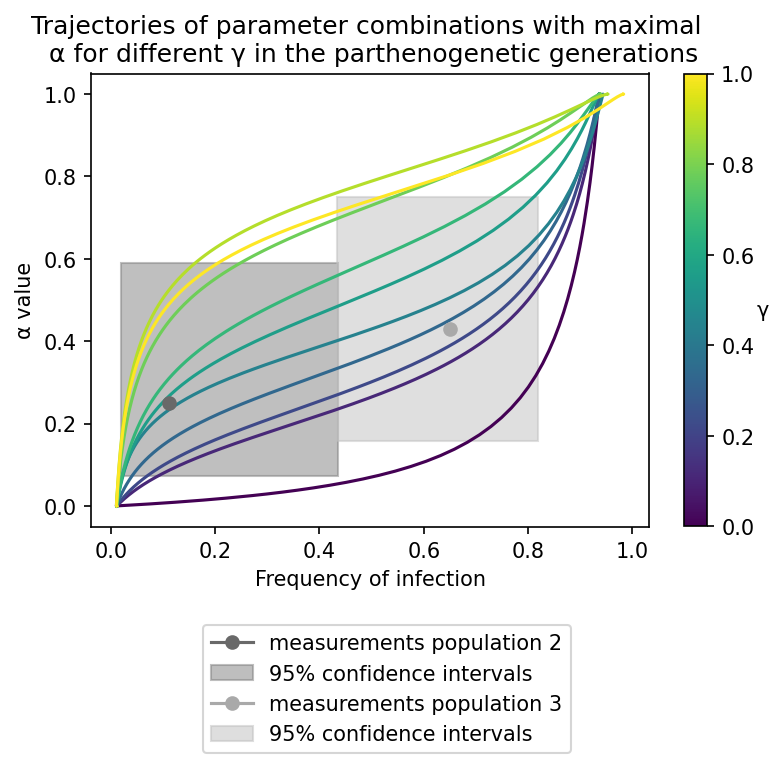

In [28]:
############################################################################
#### Figure 2: #############################################################
#### Plotting the trajectories of the combinations resulting in maximum ####
#### alpha values and comparing them to the measured alpha values ##########
############################################################################

# This time we set up a more detailed timespan to visualize the final results:
t2 = np.linspace(0,1500,1500)

## The initial infection frequency:
F0THzero = 0.01


#### Plot of maximum mtDNA values in parthenogenetic generation containing populations 2 and 3 #########

# Setting up the colormap used to symbolize different levels of CI:
normalize = mcolors.Normalize(0,1)
colormap = cm.viridis

# The basic plot:
plt.figure(dpi=150)
plt.xlabel('Frequency of infection')
plt.ylabel('α value')
plt.title("Trajectories of parameter combinations with maximal \n α for different γ in the parthenogenetic generations")

# Simulate the spread of Wolbachia and the alpha values and adding the trajectories of the maximum
# alpha values for the different infection frequencies for each examined level of CI to the plot:
for γ in γ0:
    maxVal = int(MaxMinAAsex[1][MaxMinAAsex[0]==γ])
    if maxVal != -1:
        x1 = odeint(AlphaShares,FI_initial(F0THzero,combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]),t2,args=(combMatrix[maxVal,0],combMatrix[maxVal,1],combMatrix[maxVal,2],combMatrix[maxVal,3],combMatrix[maxVal,4]))[:,1]
        y1 = odeint(AlphaShares,FI_initial(F0THzero,combMatrix[INDlist[j],2],combMatrix[INDlist[j],3],combMatrix[INDlist[j],4]),t2,args=(combMatrix[maxVal,0],combMatrix[maxVal,1],combMatrix[maxVal,2],combMatrix[maxVal,3],combMatrix[maxVal,4]))[:,3]
        plt.plot(x1,y1,c=colormap(normalize(γ)))

# Plot the legend of the colormap:
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(γ0)
cbar= plt.colorbar(scalarmappaple)
cbar.set_label('γ', rotation=0)

# Add the measured alpha value as a point and the area in which values do not differ from it significantly
# in a rectangle around it:
# For population 2:
plt.plot(infPop2/totalPop2,AlphamtDNAPop2/(totalPop2-infPop2),marker='o',color="dimgray",label="measurements population 2")
rectangle = plt.Rectangle((FDIGmtDNAPop2_95[0],FinfPop2_95[0]), FDIGmtDNAPop2_95[1]-FDIGmtDNAPop2_95[0],FinfPop2_95[1]-FinfPop2_95[0],alpha=0.5,color="gray",label="95% confidence intervals")
plt.gca().add_patch(rectangle)

# For population 3:
plt.plot(infPop3/totalPop3,AlphamtDNAPop3/(totalPop3-infPop3),marker='o',color="darkgray",label="measurements population 3")
rectangle = plt.Rectangle((FDIGmtDNAPop3_95[0],FinfPop3_95[0]), FDIGmtDNAPop3_95[1]-FDIGmtDNAPop3_95[0],FinfPop3_95[1]-FinfPop3_95[0],alpha=0.5,color="silver",label="95% confidence intervals")
plt.gca().add_patch(rectangle)

# Plot the legend:
plt.legend(loc=(0.2,-0.5))